<a href="https://colab.research.google.com/github/Jorbnc/MAIA-DL/blob/master/Mini_Proyecto_3_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

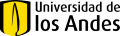

<style>
@import url('https://fonts.googleapis.com/css2?family=Latin+Modern+Roman:wght@400;700&display=swap');

body, p, h1, h2, h3, h4, h5, h6, li {
  font-family: 'Latin Modern Roman', serif;
}
code, pre {
  font-family: 'Fira Mono', monospace;
}
</style>

***

# **Miniproyecto 3, Técnicas de *Deep Learning*: ...**

## **Descripción del problema:**

...

## **Objetivo:**

...

***

**Este proyecto es realizado por Andrés Felipe Ñungo y Jordan Bryan Núñez Campos para entrega el 13 de mayo de 2025.**



***
# **Índice**

El *notebook* aborda el proyecto con la siguiente estructura:

| 🔹 | Sección        |
|----|----------------|
| 1️⃣. | **Instalación y carga de librerías** |
| 1️⃣.1️⃣. | **Word2Vec** |
| 1️⃣.2️⃣. | **GloVe** |
| 1️⃣.3️⃣. | **Configuraciones adicionales** |
| 2️⃣. | **Análisis exploratorio y preparación de los datos**       |
| 2️⃣.1️⃣. | **Carga y estadísticas generales**       |
| 2️⃣.2️⃣. | **Limpieza de los datos**       |
| 3️⃣. | **Definición de *pipelines* de procesamiento**          |
| 3️⃣.1️⃣. | **Pipeline de preprocesamiento**   |
| 4️⃣. | **Desarrollo del modelo RNN**   |
| 4️⃣.1️⃣. | **Hiperparámetros, Partición y DataLoaders**   |
| 4️⃣.2️⃣. | **Definición del modelo**   |
| 4️⃣.3️⃣. | **Entrenamiento, validación y prueba**   |
| 5️⃣. | **Análisis de resultados y discusión**   |
| 5️⃣.1️⃣. | **Pruebas individuales del modelo**   |
| 6️⃣. | **Conclusión**   |
| 7️⃣. | **Referencias**   |


***

# 1. Instalación y carga de librerías

....

In [44]:
# Instalación de librerías necesarias para correr en Colab/Coursera
!pip -q install kagglehub langdetect wordcloud matplotlib scikit-learn plotly

In [45]:
# Librerías comunes
import os, random, sys, time, gc
import subprocess
from pathlib import Path
import numpy as np
import pandas as pd

# Descarga de datasets y de embeddings
import kagglehub

# Limipieza y preparación de los txtos
from langdetect import detect, DetectorFactory
import re

# Preprocesamiento y herramientas de PLN
from sklearn.preprocessing import LabelEncoder
from transformers import (BertTokenizer,
                          BertForSequenceClassification,
                          get_linear_schedule_with_warmup)

# Modelado
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader

# Evaluación
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Librerías para visualizaciones
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import plotly.express as px
from wordcloud import WordCloud

Uses “bert-base-uncased” version of BERT, which is pre-trained on lower-cased English text

(with 12-layer, 768-hidden, 12-heads, 110M parameters)

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the BERT paper: https://arxiv.org/pdf/1810.04805.pdf):

*   **Batch size:** 16, 32
*   **Learning rate (Adam):** 5e-5, 3e-5, 2e-5
*   **Number of epochs:** 2, 3, 4

[1]

In [3]:
#Parámetros globales de los modelos
MODEL_NAMES = [  # (checkpoint, alias para impresión)
    ("bert-base-uncased", "BERT"),
    ("roberta-base", "RoBERTa"),
]
MAX_LEN     = 256
BATCH_SIZE  = 16
EPOCHS      = 3
LR          = 2e-5
RANDOM_SEED = 13

Se descarga el conjunto de datos de reseñas de noticias de la BBC de **`kagglehub`**. La función **`dataset_download`** guarda los archivos de manera local y devuelve la ruta absoluta, que se almacena en **`path`** y se muestra en pantalla mediante **`print`** para confirmar dónde quedaron los datos.

## 1.3. Configuraciones adicionales

Con el siguiente bloque se detecta si el entorno dispone de GPU y selecciona el **`device`** apropiado para PyTorch.  

Primero se llama a **`is_available()`**, que devuelve *True* si se ha asignado una GPU CUDA al *runtime* de Colab. Según el resultado se imprime un mensaje informativo. Posteriormente, se construye el objeto **`device`**, que será pasado a la red y a los tensores de entrada para que se ubiquen en la GPU cuando sea posible. Por último se muestra en pantalla el dispositivo elegido.

In [5]:
# Devuelve asignación de GPU
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo activo → {DEVICE}")

Dispositivo activo → cuda


Adicionalmente se ocultan avisos para mantener limpias algunas salidas del notebook; y se imprimen las versiones de un conjunto de librerías clave ( **`numpy`**, **`pandas`**, **`torch`**, **`scikit-learn`**, **`kagglehub`**, **`matplotlib`**). Mostrar estas versiones al inicio del notebook facilita la reproducibilidad y ayuda a depurar posibles conflictos de dependencias.

In [6]:
# Ignorar las warnings
import warnings
warnings.filterwarnings("ignore")

# Versiones utilizadas
from importlib.metadata import version
librerias = ["numpy", "pandas", "torch", "scikit-learn", "kagglehub","matplotlib", "nltk"]
for library in librerias:
  print(library, ": ", version(library))

numpy :  2.0.2
pandas :  2.2.2
torch :  2.6.0+cu124
scikit-learn :  1.6.1
kagglehub :  0.3.12
matplotlib :  3.10.0
nltk :  3.9.1


Finalmente, para cerrar esta sección se configuran algunas semillas para tener cierto grado de control en la aleatoriedad.

In [7]:
# Definición del random state y seeds
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
DetectorFactory.seed = RANDOM_SEED

***

# 2. Análisis exploratorio y preparación de los datos


***

## 2.1. Carga y estadísticas generales

In [35]:
# Leer el conjunto de datos y cargarlo a un dataframe

# Descarga del conjunto de datos
path = kagglehub.dataset_download("jacopoferretti/bbc-articles-dataset")
print("Datos descargados en:", path)

CSV_PATH = os.path.join(path, "bbc_news_text_complexity_summarization.csv")
print(f"Dataset descargado en: {CSV_PATH}")

data_raw = pd.read_csv(CSV_PATH)
print("Filas totales:", len(data_raw))

Dataset descargado en: /kaggle/input/bbc-articles-dataset/bbc_news_text_complexity_summarization.csv
Filas totales: 2127


***

## 2.2. Limpieza de los datos

En estas sección identificamos y corregimos:

* Valores faltantes
* Textos duplicados
* Textos en otros idiomas distintos al inglés

In [36]:
data_raw.isna().sum()

,0
text,0
labels,0
no_sentences,0
Flesch Reading Ease Score,0
Dale-Chall Readability Score,0
text_rank_summary,0
lsa_summary,0


In [37]:
data_raw.duplicated().sum()

np.int64(0)

In [38]:
df = data_raw.copy()

In [ ]:
le = LabelEncoder()
df["label_id"] = le.fit_transform(df["label"])  # 'label' → str  / 'label_id' → int

In [ ]:
# Gráfica para mostrar distribución de las clases

In [39]:
def detectar_idiomas(df: pd.DataFrame,
                     col_texto: str = 'text') -> pd.DataFrame:
    """
    Detecta el idioma de cada fila en la columna **col_texto**,
    añade la columna **idioma** y muestra ejemplos no ingleses.
    """
    # Inicializamos con 'desconocido'
    df['idioma'] = 'desconocido'

    # Función auxiliar segura
    def _detectar(texto):
        if isinstance(texto, str) and texto.strip():
            try:
                return detect(texto)
            except Exception:
                return 'desconocido'
        return 'desconocido'

    # Aplicamos detección
    df['idioma'] = df[col_texto].apply(_detectar)

    # Filtramos los que no son inglés
    mask = df['idioma'] != 'en'
    idx_no_en = df[mask].index

    if len(idx_no_en) > 0:
        print(f"Se encontraron {len(idx_no_en)} textos NO en inglés (ejemplos):")
        # Mostramos hasta 5 ejemplos
        for i in idx_no_en[:5]:
            print(f" • Índice {i}: [{df.at[i,'idioma']}] {df.at[i,col_texto][:100]}...")
    else:
        print("Todos los textos están detectados como inglés.")

    return df

Nota: En algunas ocasiones, la función `detect` confunde la presencia de nombres propios o pequeñas secciones en otros idiomas como un indicativo de que el texto no está en inglés. Sin embargo, estas ocurrencias suelen ser mínimas o nulas.

Detectando otros idiomas:

In [43]:
df = detectar_idiomas(df, col_texto='text')

Todos los textos están detectados como inglés.


***

# 3. Definición de *pipelines* de procesamiento

***

## 3.1. *Pipeline* de preprocesamiento

....

In [46]:
# Limpieza básica
def clean_text(text: str) -> str:
    text = re.sub(r"\s+", " ", text)            # colapsar whitespace
    text = re.sub(r"[^\w.,;:!?()¿¡ ]+", "", text)
    return text.strip()

for col in ("text", "text_rank_summary", "lsa_summary"):
    if col in df.columns:
        df[col] = df[col].astype(str).apply(clean_text)

labels      = sorted(df["labels"].unique())
label2id    = {lbl: idx for idx, lbl in enumerate(labels)}
id2label    = {idx: lbl for lbl, idx in label2id.items()}
df["labels"] = df["labels"].map(label2id)

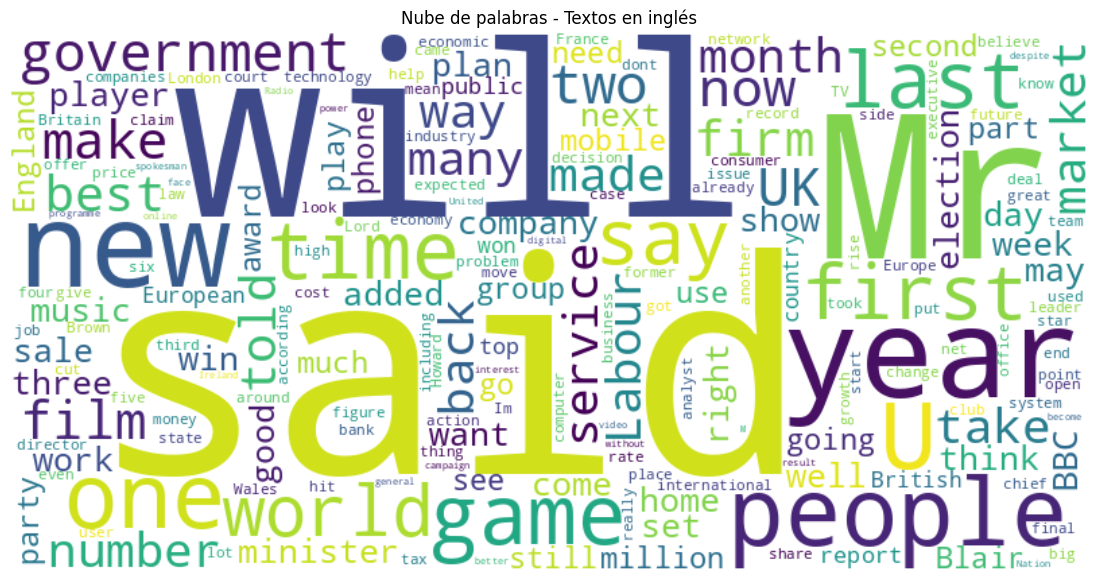

In [47]:
# --- 4.b. Nube de palabras para artículos en inglés ---
# Unimos todos los textos limpios de la columna 'text' detectados como inglés
textos_en = ' '.join(df[df['idioma'] == 'en']['text'].tolist())

# Creamos la nube de palabras
wc = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200,
    collocations=False  # evita duplicados de bigramas
).generate(textos_en)

# Mostramos la figura
plt.figure(figsize=(15, 7))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de palabras - Textos en inglés')
plt.show()


In [16]:
train_df, test_df = train_test_split(
    df, test_size=0.10, stratify=df["labels"], random_state=RANDOM_SEED
)
train_df, val_df = train_test_split(
    train_df, test_size=0.10, stratify=train_df["labels"], random_state=RANDOM_SEED
)
print("Tamaños – Train / Val / Test:", len(train_df), len(val_df), len(test_df))

Tamaños – Train / Val / Test: 1530 171 426


[2]

***

# 4. Desarrollo del modelo RNN

***

## 4.1. Hiperparámetros, partición y *DataLoaders*

...

In [17]:
class BBCDataset(Dataset):
    def __init__(self, df, tokenizer, max_len):
        self.texts   = df["text"].tolist()
        self.labels  = df["label_id"].tolist()
        self.tokenizer = tokenizer
        self.max_len  = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )
        # Squeeze para quitar la dimensión batch ficticia
        item = {k: v.squeeze() for k, v in enc.items()}
        item["labels"] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

In [18]:
def build_dataloaders(splits: dict, tokenizer, max_len: int, batch_size: int, num_workers: int = 2):
    """Crea DataLoaders, uno por split, sin dejar referencias globales."""
    return {
        split: DataLoader(
            BBCDataset(df_split, tokenizer, max_len),
            batch_size=batch_size,
            shuffle=(split == "train"),
            num_workers=num_workers,
            pin_memory=True,
        )
        for split, df_split in splits.items()
    }

In [24]:
# -----------------------------------------------------
# 4. Función train_and_evaluate  >>> MODIFIED <<<
# -----------------------------------------------------

def train_and_evaluate(
    ckpt: str,
    name: str,
    splits: dict,
    target_names: list,
    device: torch.device,
    *,
    epochs: int = EPOCHS,
    lr: float = LR,
    batch_size: int = BATCH_SIZE,
    max_len: int = MAX_LEN,
):
    """Entrena y evalúa un modelo, liberando memoria al terminar."""

    tokenizer = AutoTokenizer.from_pretrained(ckpt, use_fast=True)
    loaders   = build_dataloaders(splits, tokenizer, max_len, batch_size)

    model = AutoModelForSequenceClassification.from_pretrained(
        ckpt, num_labels=len(target_names)
    ).to(device)

    opt   = torch.optim.AdamW(model.parameters(), lr=lr)
    tot_steps = len(loaders["train"]) * epochs
    sched = get_linear_schedule_with_warmup(opt, int(0.1 * tot_steps), tot_steps)

    history = {k: [] for k in ("train_loss", "val_loss", "train_acc", "val_acc")}

    for ep in range(1, epochs + 1):
        for phase in ("train", "val"):
            is_train = phase == "train"
            model.train() if is_train else model.eval()

            losses, preds, trues = [], [], []
            for batch in loaders[phase]:
                batch = {k: v.to(device) for k, v in batch.items()}

                with torch.set_grad_enabled(is_train):
                    out  = model(**batch)
                    loss = out.loss
                    logits = out.logits

                if is_train:  # backward only in training
                    loss.backward()
                    nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    opt.step(); sched.step(); opt.zero_grad()

                losses.append(loss.item())
                preds.extend(logits.argmax(1).cpu().numpy())
                trues.extend(batch["labels"].cpu().numpy())

            acc = accuracy_score(trues, preds)
            if is_train:
                history["train_loss"].append(np.mean(losses))
                history["train_acc"].append(acc)
            else:
                history["val_loss"].append(np.mean(losses))
                history["val_acc"].append(acc)
            print(f"Epoch {ep} {phase.capitalize()} – Loss: {np.mean(losses):.4f}, Acc: {acc:.3f}")

    # ---------- Test split ----------
    model.eval(); test_preds, test_trues = [], []
    for batch in loaders["test"]:
        b = {k: v.to(device) for k, v in batch.items()}
        logits = model(**b).logits
        test_preds.extend(logits.argmax(1).cpu().numpy())
        test_trues.extend(b["labels"].cpu().numpy())

    report = classification_report(test_trues, test_preds, target_names=target_names, digits=3)

    # Liberar memoria explícitamente  >>> MODIFIED <<<
    del model, loaders
    torch.cuda.empty_cache(); gc.collect()

    return history, report

....

***

## 4.3. Entrenamiento, validación y prueba

 **`gradient clipping`** m

In [ ]:
def plot_history(hist):
    epochs = list(range(1,len(hist['train_loss'])+1))
    plt.figure(figsize=(8,4))
    plt.plot(epochs,hist['train_loss'],label='Train Loss')
    plt.plot(epochs,hist['val_loss'],label='Val Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.title('Loss vs Epoch'); plt.legend(); plt.show()

    plt.figure(figsize=(8,4))
    plt.plot(epochs,hist['train_acc'],label='Train Acc')
    plt.plot(epochs,hist['val_acc'],label='Val Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy'); plt.title('Accuracy vs Epoch'); plt.legend(); plt.show()


[3]

In [27]:
# ===============================================================
# 8. Loop sobre cada modelo y recolección de métricas
# ===============================================================

target_names = le.classes_.tolist()
splits = {"train": train_df, "val": val_df, "test": test_df}

results = {}
for ckpt, name in MODEL_NAMES:
    print(f"\n### Modelo: {name} ###")
    hist, rep = train_and_evaluate(
        ckpt, name, splits, target_names, DEVICE,
        epochs=EPOCHS, lr=LR, batch_size=BATCH_SIZE, max_len=MAX_LEN
    )
    plot_history(hist)
    print(f"\n--- Test Report for {name} ---\n", rep)
    results[name] = {"history": hist, "report": rep}


Entrenando modelo: BERT  (bert-base-uncased)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3
Train Loss: 0.9125
Val   Loss: 0.1611
               precision    recall  f1-score   support

     business      0.951     0.975     0.963        40
entertainment      0.968     1.000     0.984        30
     politics      1.000     0.969     0.984        32
        sport      1.000     1.000     1.000        41
         tech      1.000     0.964     0.982        28

     accuracy                          0.982       171
    macro avg      0.984     0.982     0.983       171
 weighted avg      0.983     0.982     0.983       171


Epoch 2/3
Train Loss: 0.0971
Val   Loss: 0.0929
               precision    recall  f1-score   support

     business      0.929     0.975     0.951        40
entertainment      1.000     1.000     1.000        30
     politics      0.939     0.969     0.954        32
        sport      1.000     0.976     0.988        41
         tech      1.000     0.929     0.963        28

     accuracy                          0.971       171
    macro avg    

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/3
Train Loss: 0.8419
Val   Loss: 0.0521
               precision    recall  f1-score   support

     business      1.000     0.975     0.987        40
entertainment      1.000     1.000     1.000        30
     politics      0.969     0.969     0.969        32
        sport      1.000     1.000     1.000        41
         tech      0.966     1.000     0.982        28

     accuracy                          0.988       171
    macro avg      0.987     0.989     0.988       171
 weighted avg      0.989     0.988     0.988       171


Epoch 2/3
Train Loss: 0.0696
Val   Loss: 0.0461
               precision    recall  f1-score   support

     business      0.975     0.975     0.975        40
entertainment      0.968     1.000     0.984        30
     politics      1.000     0.969     0.984        32
        sport      1.000     0.976     0.988        41
         tech      0.966     1.000     0.982        28

     accuracy                          0.982       171
    macro avg    

...

***


# 5. Análisis de resultados y discusión

...

...

In [33]:
# ===============================================================
# 9. Resumen comparativo final
# ===============================================================
print("\n# Resumen comparativo final #")
for name, res in results.items():
    print(f"\nModel: {name}\n", res["report"])



#########################  RESUMEN COMPARATIVO  #########################

>> BERT
               precision    recall  f1-score   support

     business      0.942     0.970     0.956       101
entertainment      0.986     0.986     0.986        74
     politics      0.952     0.975     0.963        81
        sport      1.000     0.980     0.990       101
         tech      1.000     0.957     0.978        69

     accuracy                          0.974       426
    macro avg      0.976     0.974     0.975       426
 weighted avg      0.975     0.974     0.974       426


>> RoBERTa
               precision    recall  f1-score   support

     business      0.980     0.980     0.980       101
entertainment      0.987     1.000     0.993        74
     politics      0.975     0.975     0.975        81
        sport      1.000     1.000     1.000       101
         tech      1.000     0.986     0.993        69

     accuracy                          0.988       426
    macro avg     

In [ ]:
# Mariz de confusión de ambos modelos

In [ ]:
# ——————————————————————————————————————————————
# 10. t-SNE 3D de los embeddings de entrada
# ——————————————————————————————————————————————

N = 500  # número de tokens a mostrar por vocabulario

# 1) Obtener los N primeros tokens de cada tokenizer
tokens_bert    = list(tokenizer_bert.get_vocab().keys())[:N]
tokens_roberta = list(tokenizer_roberta.get_vocab().keys())[:N]

# 2) Extraer sus vectores de embedding
#    get_input_embeddings().weight es [vocab_size x hidden_size]
emb_bert    = model_bert.get_input_embeddings().weight.detach().cpu().numpy()
emb_roberta = model_roberta.get_input_embeddings().weight.detach().cpu().numpy()

# 3) Indexar sólo los tokens seleccionados
ids_bert    = [tokenizer_bert.convert_tokens_to_ids(t) for t in tokens_bert]
ids_roberta = [tokenizer_roberta.convert_tokens_to_ids(t) for t in tokens_roberta]

vecs_bert    = emb_bert[ids_bert, :]
vecs_roberta = emb_roberta[ids_roberta, :]

# 4) Concatenar y normalizar
V = np.vstack([vecs_bert, vecs_roberta])
V = StandardScaler().fit_transform(V)

# 5) Reducir dimensionalidad con PCA a 50 componentes
pca    = PCA(n_components=50, random_state=RANDOM_SEED)
V_pca  = pca.fit_transform(V)

# 6) t-SNE en 3D
tsne   = TSNE(
    n_components=3,
    perplexity=40,
    init='pca',
    random_state=RANDOM_SEED,
    learning_rate='auto'
)
X_tsne = tsne.fit_transform(V_pca)

# 7) Preparar DataFrame para Plotly
df_vis = pd.DataFrame({
    'x':       X_tsne[:, 0],
    'y':       X_tsne[:, 1],
    'z':       X_tsne[:, 2],
    'token':   tokens_bert + tokens_roberta,
    'modelo':  ['BERT'] * N + ['RoBERTa'] * N
})

# 8) Gráfico interactivo 3D
fig = px.scatter_3d(
    df_vis,
    x='x', y='y', z='z',
    color='modelo',
    hover_name='token',
    title='t-SNE 3D — Embeddings de entrada de BERT vs. RoBERTa'
)
fig.update_traces(marker=dict(size=3))
fig.show()


***


# 6. Conclusión

.....

***


# 7. Referencias

[1] **BERT: Pre-training of Deep Bidirectional Transformers for
Language Understanding  Google AI Language**  
Disponible en: [arxiv.org](https://arxiv.org/abs/1810.04805)


[2] **Documents Classification using BERT on BBC Dataset**  
Disponible en: [kaggle.com](https://www.kaggle.com/code/ouardasakram/documents-classification-using-bert-on-bbc-dataset)


[3] **Bert-Classification-BBC-News**  
Disponible en: [github.com](https://github.com/bymi15/Bert-Classification-BBC-News/blob/main/bert_classification_bbc_news.ipynb)


